<a href="https://colab.research.google.com/github/MikhailKalikin/CNN_RNN_LAB2/blob/main/6132_KalikinMA_lab2_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import datetime
import IPython
import IPython.display

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
df = pd.read_csv('AAPL.csv')


В этом руководстве будут рассматриваться только почасовые прогнозы , поэтому начните с подвыборки данных с 10-минутных интервалов на одночасовые:

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-01-03,3.081786,3.092143,2.925000,2.992857,2.551165,1238319600
1,2007-01-04,3.001786,3.069643,2.993571,3.059286,2.607791,847260400
2,2007-01-05,3.063214,3.078571,3.014286,3.037500,2.589220,834741600
3,2007-01-08,3.070000,3.090357,3.045714,3.052500,2.602005,797106800
4,2007-01-09,3.087500,3.320714,3.041071,3.306071,2.818155,3349298400


Эволюция некоторых функций с течением времени:

          Date      Open      High       Low     Close  Adj Close      Volume
5   2007-01-10  3.383929  3.492857  3.337500  3.464286   2.953020  2952880000
11  2007-01-19  3.165357  3.201786  3.147143  3.160714   2.694248  1364473600
17  2007-01-29  3.082143  3.094643  3.054643  3.069286   2.616314   901664400
23  2007-02-06  3.016071  3.016786  2.959286  3.005357   2.561820   864393600
29  2007-02-14  3.022500  3.058571  3.020357  3.046429   2.596831   507981600


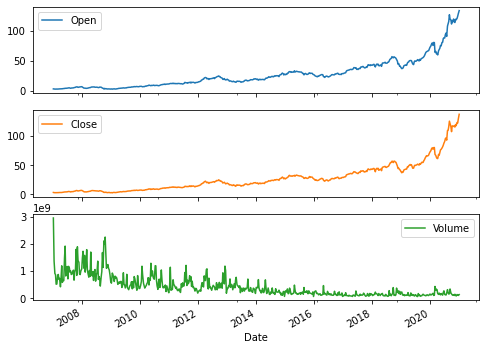

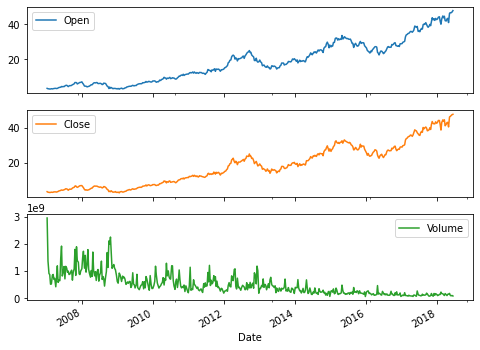

In [6]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
df = pd.read_csv("AAPL.csv", delimiter=",")
df = df[5::6]
print(df.head())
date_time = pd.to_datetime(df.pop('Date'), format='%Y.%m.%d')
plot_cols = ['Open', 'Close', 'Volume']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)
plt.show()

Очистка

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,587.0,2.757621e+01,2.477282e+01,2.926071e+00,9.270893e+00,2.149286e+01,3.742125e+01,1.339900e+02
High,587.0,2.785630e+01,2.506193e+01,2.928571e+00,9.359643e+00,2.167500e+01,3.783250e+01,1.373400e+02
Low,587.0,2.726138e+01,2.439523e+01,2.792857e+00,9.108929e+00,2.122036e+01,3.696750e+01,1.335100e+02
Close,587.0,2.756155e+01,2.471348e+01,2.792857e+00,9.196250e+00,2.130500e+01,3.738625e+01,1.366900e+02
Adj Close,587.0,2.580200e+01,2.460242e+01,2.380681e+00,7.839047e+00,1.870205e+01,3.554922e+01,1.350686e+02
Volume,587.0,4.185370e+08,3.868519e+08,5.428160e+07,1.372594e+08,2.864540e+08,5.666752e+08,2.952880e+09


Выполним разделение на выборки

In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

Нормализуем данные

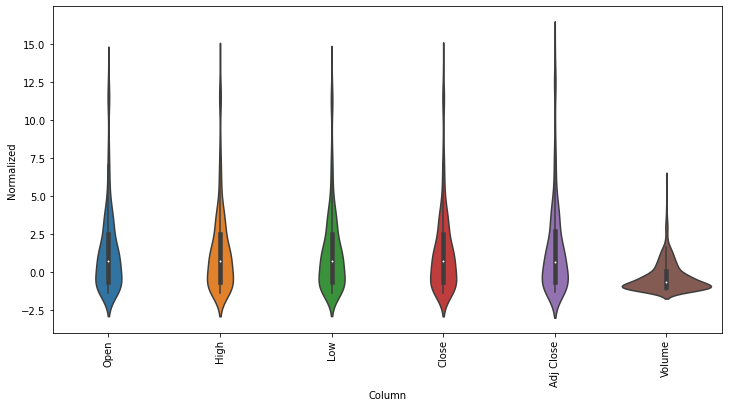

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Окно данных

Модели в этом руководстве будут делать набор прогнозов на основе окна последовательных выборок из данных.

Основные особенности окон ввода:

Ширина (количество временных шагов) окон ввода и метки.
Смещение времени между ними.
Какие функции используются в качестве входных данных, меток или того и другого.
В этом руководстве создаются различные модели (включая линейные модели, модели DNN, CNN и RNN) и используются они для обеих целей:

Прогнозы с одним выходом и несколькими выходами .
Прогнозы с одним и несколькими временными шагами .
В этом разделе основное внимание уделяется реализации окна данных, чтобы его можно было повторно использовать для всех этих моделей.

В зависимости от задачи и типа модели может потребоваться создание различных окон данных. Вот некоторые примеры:

Например, чтобы сделать один прогноз на 24 часа вперед, учитывая 24-часовую историю, вы можете определить окно следующим образом:

Одно предсказание на 24 часа вперед.

Модель, которая делает прогноз на один час вперед, учитывая шесть часов истории, нуждалась бы в таком окне:

Одно предсказание на час вперед.

В оставшейся части этого раздела определяется класс WindowGenerator . Этот класс может:

Обрабатывайте индексы и смещения, как показано на диаграммах выше.
Разделить окна функций на пары (features, labels) .
Постройте содержимое получившихся окон.
Эффективно генерируйте пакеты этих окон из обучающих, оценочных и тестовых данных, используя tf.data.Dataset s.
1. Индексы и смещения
Начните с создания класса WindowGenerator . Метод __init__ включает всю необходимую логику для индексов ввода и меток.

Он также принимает обучающие, оценочные и тестовые кадры данных в качестве входных данных. Позже они будут преобразованы в tf.data.Dataset окон.

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Open']
Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Open']
All shapes are: (batch, time, features)
Window shape: (3, 7, 6)
Inputs shape: (3, 6, 6)
Labels shape: (3, 1, 1)


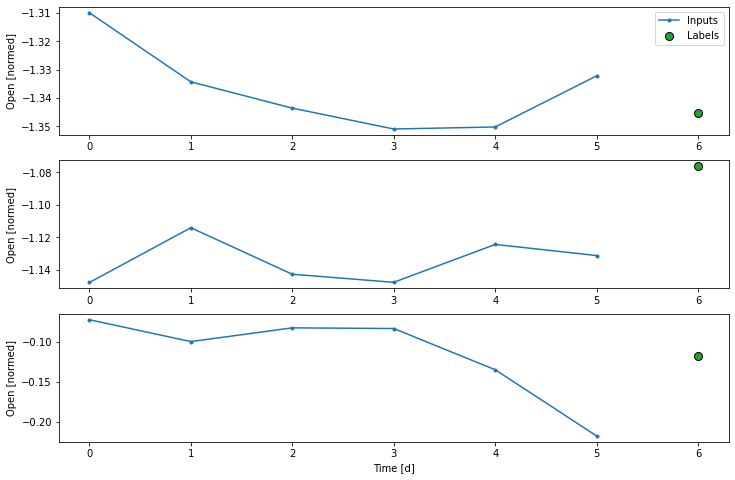

In [10]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
            self.column_indices = {name: i for i, name in
                                        enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])


w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                    label_columns=['Open'])
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                    label_columns=['Open'])
print(w1)
print(w2)


def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels


WindowGenerator.split_window = split_window
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                            np.array(train_df[100:100+w2.total_window_size]),
                            np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

w2.example = example_inputs, example_labels


def plot(self, model=None, plot_col='Open', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [d]')


WindowGenerator.plot = plot
w2.plot()
plt.show()



Создайте tf.data.Dataset s
Наконец, этот метод make_dataset возьмет временной ряд DataFrame и преобразует его в tf.data.Dataset из пар (input_window, label_window) с помощью функции tf.keras.utils.timeseries_dataset_from_array :

In [11]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)
    return ds


WindowGenerator.make_dataset = make_dataset


@property
def train(self):
    return self.make_dataset(self.train_df)


@property
def val(self):
    return self.make_dataset(self.val_df)


@property
def test(self):
    return self.make_dataset(self.test_df)


@property
def example(self):
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
print(w2.train.element_spec)
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

(TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Inputs shape (batch, time, features): (32, 6, 6)
Labels shape (batch, time, features): (32, 1, 1)


Одноступенчатые модели
Самая простая модель, которую вы можете построить на такого рода данных, — это модель, которая предсказывает значение одной функции — 1 временной шаг (один час) в будущее, основываясь только на текущих условиях.

In [12]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Open'])
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 6)
Labels shape (batch, time, features): (32, 1, 1)


# Базовый уровень
Перед созданием обучаемой модели было бы неплохо иметь базовый уровень производительности в качестве точки для сравнения с более позд-ними более сложными моделями.
Эта первая задача состоит в том, чтобы предсказать цену открытия на один день вперед, учитывая текущее значение всех признаков. Текущие значения включают текущую цену.
Итак, начнем с модели, которая просто возвращает текущую цену в качестве прогноза, прогнозируя «без изменений». Это разумная базовая линия, поскольку цена изменяется медленно.
В качестве потерь используем tf.losses.MeanSquaredError. Вычисляет среднее квадратическое значение ошибок между метками и прогнозами.
В качестве метрик tf.metrics.MeanAbsoluteError. Вычисляет среднюю абсолютную ошибку между метками и прогнозами.
Модель делает прогнозы на один день вперед на основе одного входного временного шага


4/4 [==============================] - 0s 4ms/step - loss: 0.0327 - mean_absolute_error: 0.1319
Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


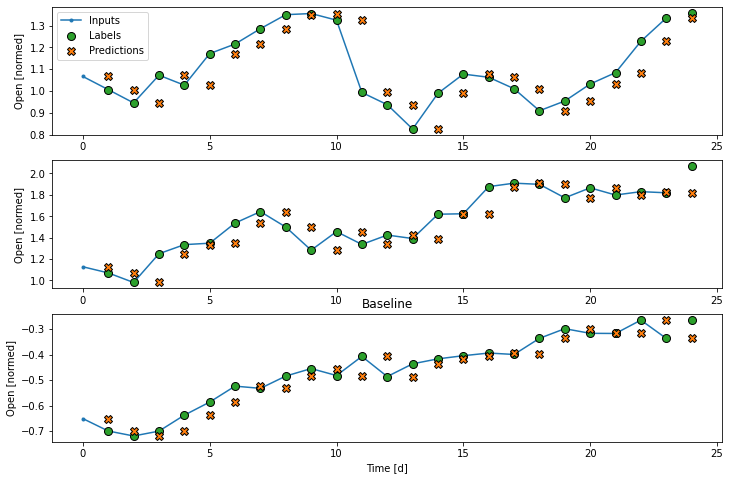

In [13]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


#Создаем экземпляр и оцениваем эту модель:

baseline = Baseline(label_index=column_indices['Open'])

baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Open'])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
wide_window.plot(baseline)
plt.title("Baseline")
plt.show()

Линейная модель
Самая простая обучаемая модель, которую вы можете применить к этой задаче, — это вставить линейное преобразование между входом и выходом. В этом случае результат временного шага зависит только от этого шага:

Одношаговое предсказание

Слой tf.keras.layers.Dense без набора activation является линейной моделью. Слой преобразует только последнюю ось данных из (batch, time, inputs) в (batch, time, units) ; он применяется независимо к каждому элементу по осям batch и time .

Input shape: (32, 1, 6)
Output shape: (32, 1, 1)
Epoch 1/20
13/13 [==============================] - 1s 19ms/step - loss: 1.1565 - mean_absolute_error: 0.9324 - val_loss: 13.5029 - val_mean_absolute_error: 3.5103
Epoch 2/20
13/13 [==============================] - 0s 7ms/step - loss: 1.0131 - mean_absolute_error: 0.8711 - val_loss: 12.0065 - val_mean_absolute_error: 3.3068
Epoch 3/20
13/13 [==============================] - 0s 9ms/step - loss: 0.8855 - mean_absolute_error: 0.8121 - val_loss: 10.6228 - val_mean_absolute_error: 3.1070
Epoch 4/20
13/13 [==============================] - 0s 6ms/step - loss: 0.7697 - mean_absolute_error: 0.7552 - val_loss: 9.3829 - val_mean_absolute_error: 2.9165
Epoch 5/20
13/13 [==============================] - 0s 7ms/step - loss: 0.6667 - mean_absolute_error: 0.7012 - val_loss: 8.2695 - val_mean_absolute_error: 2.7342
Epoch 6/20
13/13 [==============================] - 0s 10ms/step - loss: 0.5804 - mean_absolute_error: 0.6520 - val_loss: 7.2330 - val_me

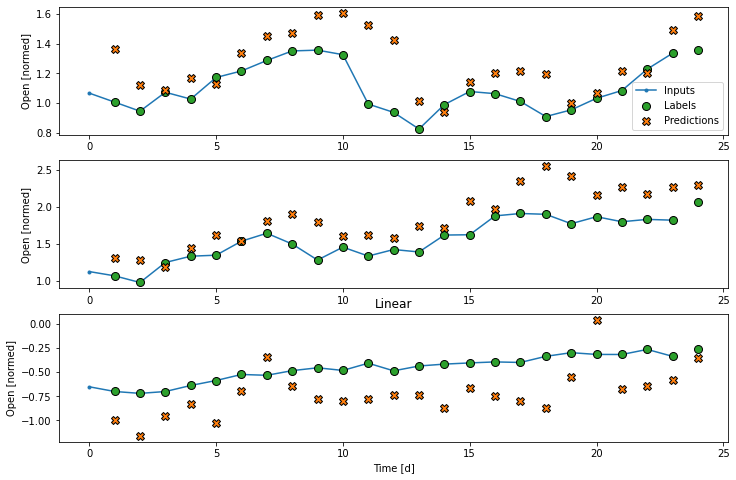

In [14]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)
MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

#Как и baseline модель, линейную модель можно вызывать для пакетов широких окон.
#При таком использовании модель делает набор независимых прогнозов на последовательных временных шагах.
#Ось time действует как другая ось batch . Между прогнозами на каждом временном шаге нет взаимодействий.

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

#Вот график его примерных прогнозов для wide_window , 
#обратите внимание, что во многих случаях прогноз явно лучше, чем просто возврат входной температуры, но в некоторых случаях он хуже:

wide_window.plot(linear)
plt.title("Linear")
plt.show()

Одним из преимуществ линейных моделей является то, что их относительно просто интерпретировать. Вы можете вытащить веса слоя и визуализировать вес, назначенный каждому входу:

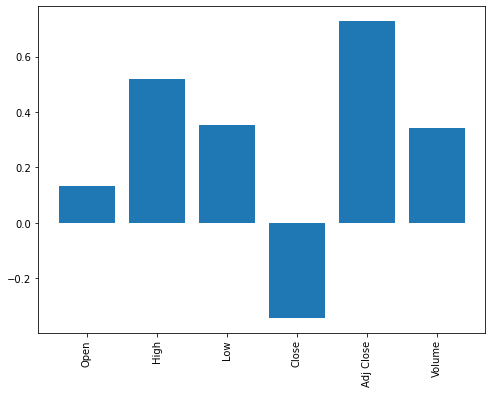

In [15]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

# Dense модель
Прежде чем применять модели, которые фактически работают с несколькими временными шагами, стоит проверить производительность более глубоких и мощных моделей с одним входным шагом.

Вот модель, похожая на linear модель, за исключением того, что между входом и выходом укладывается несколько Dense слоев:

Epoch 1/20
13/13 [==============================] - 1s 21ms/step - loss: 0.4048 - mean_absolute_error: 0.4881 - val_loss: 1.3899 - val_mean_absolute_error: 1.1197
Epoch 2/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0324 - mean_absolute_error: 0.1387 - val_loss: 0.0747 - val_mean_absolute_error: 0.2400
Epoch 3/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0198 - mean_absolute_error: 0.1033 - val_loss: 0.1025 - val_mean_absolute_error: 0.2609
Epoch 4/20
4/4 [==============================] - 0s 4ms/step - loss: 0.2074 - mean_absolute_error: 0.4001


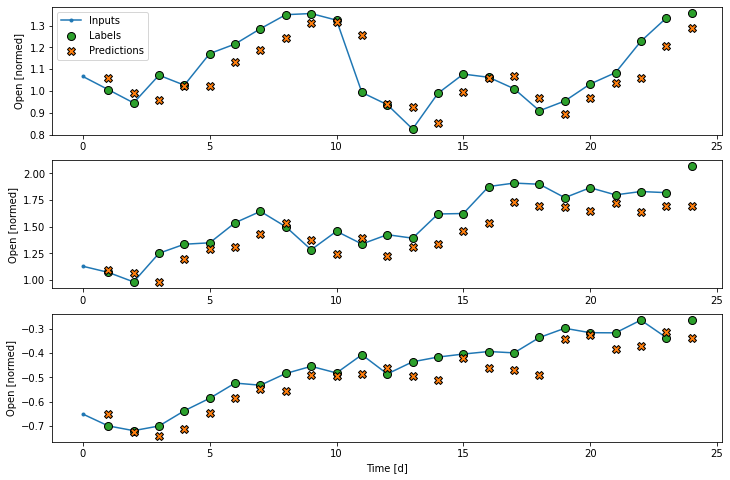

In [16]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)
wide_window.plot(dense)

# Multi-step dense
Одношаговая модель не имеет контекста для текущих значений входных данных. Он не может видеть, как входные объекты меняются с течением времени. Чтобы решить эту проблему, модели требуется доступ к нескольким временным шагам при прогнозировании:

Для каждого прогноза используются три временных шага.

baseline , linear и dense модели обрабатывали каждый временной шаг независимо. Здесь модель будет принимать несколько временных шагов в качестве входных данных для получения одного вывода.

Создайте WindowGenerator , который будет создавать пакеты трехчасовых входных данных и одночасовых меток:

Обратите внимание, что параметр shift Window относится к концу двух окон.


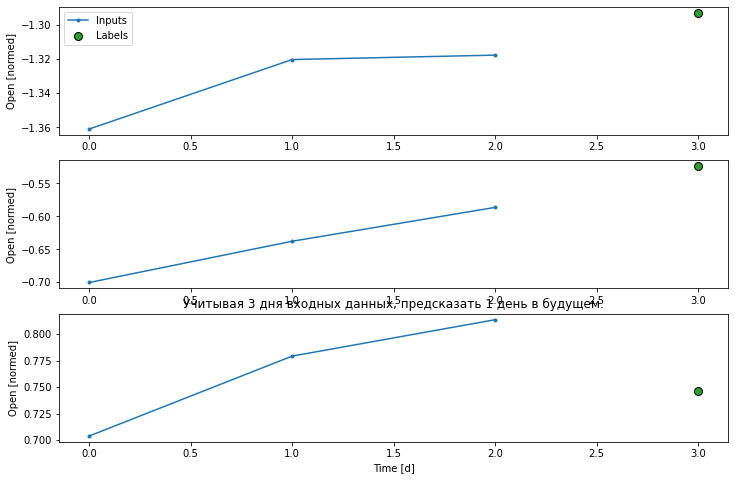

In [17]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Open'])
conv_window.plot()
plt.title("Учитывая 3 дня входных данных, предсказать 1 день в будущем.")
plt.show()


Можно обучить dense модель в окне с несколькими входными шагами, добавив tf.keras.layers.Flatten в качестве первого слоя модели:

Input shape: (32, 3, 6)
Output shape: (32, 1, 1)


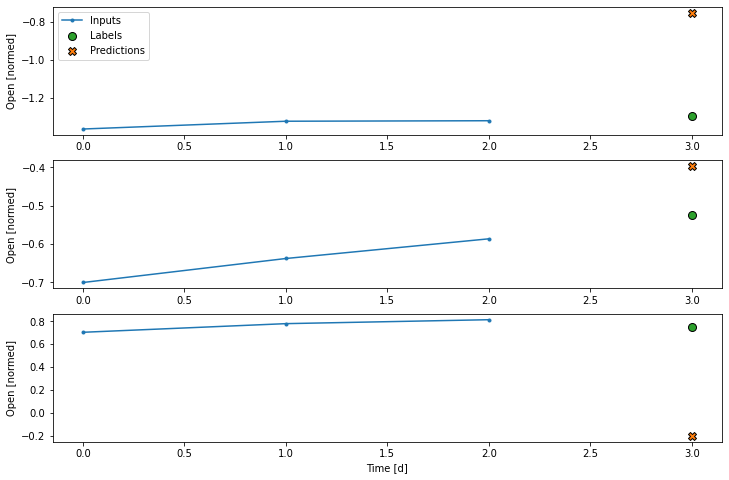

In [18]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

conv_window.plot(multi_step_dense)

Основным недостатком этого подхода является то, что результирующая модель может выполняться только на входных окнах именно такой формы.

In [19]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 6)

ValueError:Exception encountered when calling layer "sequential_2" (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 18, but received input with shape (32, 144)

Call arguments received by layer "sequential_2" (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 6), dtype=float32)
  • training=None
  • mask=None


# CNN
Слой свертки ( tf.keras.layers.Conv1D ) также использует несколько временных шагов в качестве входных данных для каждого прогноза.

Ниже представлена ​​та же модель, что и в multi_step_dense , переписанная с помощью свертки.

Обратите внимание на изменения:

tf.keras.layers.Flatten и первый tf.keras.layers.Dense заменяются tf.keras.layers.Conv1D .
tf.keras.layers.Reshape больше не нужен, так как свертка сохраняет ось времени в своих выходных данных.

In [20]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(CONV_WIDTH,), activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
#Запустите его на примере пакета, чтобы убедиться, что модель выдает выходные данные с ожидаемой формой:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

#Обучите и оцените его в conv_window и он должен дать производительность, аналогичную модели multi_step_dense .

history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

4/4 [==============================] - 0s 3ms/step - loss: 0.0423 - mean_absolute_error: 0.1592


Обратите внимание, что вывод короче ввода. Чтобы обучение или построение графика работали, вам нужно, чтобы метки и прогноз имели одинаковую длину. Поэтому создайте WindowGenerator для создания широких окон с несколькими дополнительными временными шагами ввода, чтобы длина метки и предсказания совпадала:

In [21]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Open'])



Wide conv window
Input shape: (32, 26, 6)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


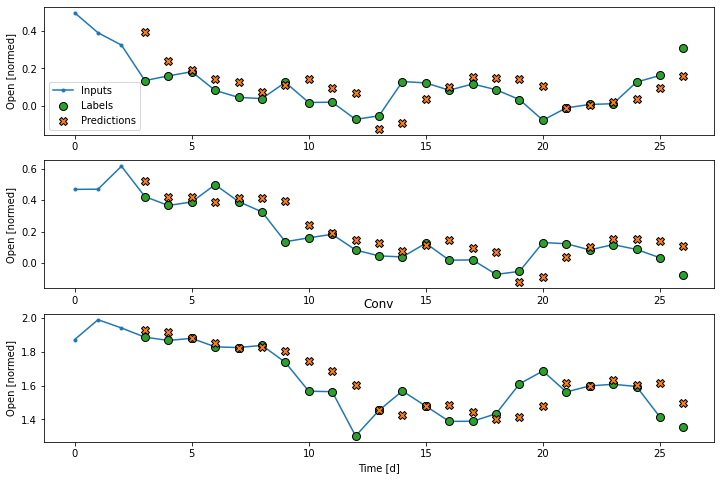

In [22]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)
wide_conv_window.plot(conv_model)
plt.title("Conv")
plt.show()

# RNN
Рекуррентная нейронная сеть (RNN) — это тип нейронной сети, хорошо подходящий для данных временных рядов. RNN обрабатывают временной ряд шаг за шагом, сохраняя внутреннее состояние от шага к шагу.

Вы можете узнать больше о создании текста с помощью учебника по RNN и о рекуррентных нейронных сетях (RNN) с руководством по Keras .

В этом руководстве вы будете использовать слой RNN под названием Long Short-Term Memory ( tf.keras.layers.LSTM ).

Важным аргументом конструктора для всех слоев Keras RNN, таких как tf.keras.layers.LSTM , является аргумент return_sequences . Этот параметр может настроить слой одним из двух способов:

Если False по умолчанию, слой возвращает только выходные данные последнего временного шага, давая модели время, чтобы прогреть свое внутреннее состояние, прежде чем делать один прогноз:
LSTM разогревается и делает один прогноз

Если True , слой возвращает результат для каждого входа. Это полезно для:
Укладка слоев RNN.
Обучение модели на нескольких временных шагах одновременно.
LSTM делает прогноз после каждого временного шага

In [23]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

С return_sequences=True модель можно обучать на данных за 24 часа за раз.

In [24]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


3/3 [==============================] - 0s 6ms/step - loss: 0.5497 - mean_absolute_error: 0.5961


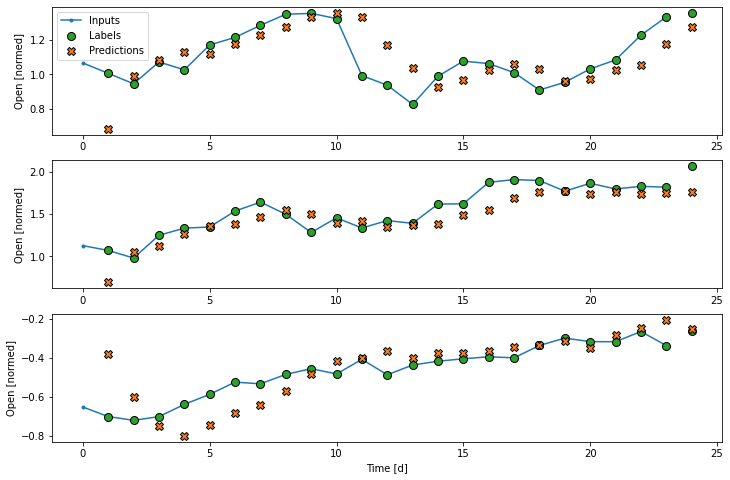

In [25]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(lstm_model)

# Performance
С этим набором данных обычно каждая из моделей работает немного лучше, чем предыдущая:


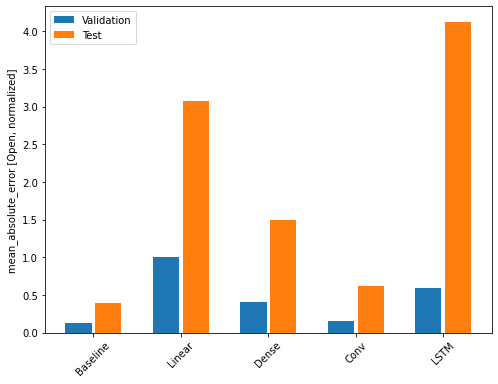

Baseline    : 0.3941
Linear      : 3.0728
Dense       : 1.4925
Conv        : 0.6153
LSTM        : 4.1238


In [26]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Open, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()
plt.show()
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

# Multi-output models

До сих пор все модели предсказывали одну выходную характеристику T (degC) для одного временного шага.

Все эти модели можно преобразовать для прогнозирования нескольких функций, просто изменив количество единиц в выходном слое и настроив окна обучения, чтобы включить все функции в labels ( example_labels ):

In [38]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 6)
Labels shape (batch, time, features): (32, 24, 6)


Обратите внимание, что ось features меток теперь имеет ту же глубину, что и входные данные, а не 1 .

# Baseline
Здесь можно использовать ту же базовую модель ( Baseline ), но на этот раз с повторением всех функций вместо выбора конкретного label_index :

In [39]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [40]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

3/3 [==============================] - 0s 5ms/step - loss: 0.0362 - mean_absolute_error: 0.1381


Dense

In [41]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [42]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

4/4 [==============================] - 0s 3ms/step - loss: 0.0801 - mean_absolute_error: 0.2051


# RNN

In [43]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

3/3 [==============================] - 0s 7ms/step - loss: 1.2932 - mean_absolute_error: 0.9109

CPU times: user 10.4 s, sys: 683 ms, total: 11.1 s
Wall time: 9.95 s


# Advanced: Residual connections

Baseline модель, использованная ранее, использовала тот факт, что последовательность не сильно меняется от одного временного шага к другому. Каждая модель, обученная в этом руководстве до сих пор, была случайным образом инициализирована, а затем должна была узнать, что результат представляет собой небольшое изменение по сравнению с предыдущим временным шагом.

Хотя вы можете обойти эту проблему с помощью тщательной инициализации, проще встроить ее в структуру модели.

В анализе временных рядов обычно строят модели, которые вместо предсказания следующего значения предсказывают, как значение изменится на следующем временном шаге. Точно так же остаточные сети — или ResNets — в глубоком обучении относятся к архитектурам, в которых каждый уровень добавляется к накапливающемуся результату модели.

Вот как вы пользуетесь знанием того, что изменение должно быть небольшим.

Модель с остаточной связью

По сути, это инициализирует модель в соответствии с Baseline . Для этой задачи это помогает моделям быстрее сходиться с немного лучшей производительностью.

Этот подход можно использовать в сочетании с любой моделью, обсуждаемой в этом руководстве.

Здесь он применяется к модели LSTM, обратите внимание на использование tf.initializers.zeros , чтобы гарантировать, что начальные прогнозируемые изменения будут небольшими и не пересилят остаточное соединение. Здесь нет проблем с нарушением симметрии для градиентов, поскольку zeros используются только на последнем слое.

In [44]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [45]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

3/3 [==============================] - 0s 7ms/step - loss: 0.0374 - mean_absolute_error: 0.1424

CPU times: user 5.33 s, sys: 148 ms, total: 5.48 s
Wall time: 5.79 s


# Performance
Вот общая производительность для этих моделей с несколькими выходами.

Baseline       : 0.3941
Linear         : 3.0728
Dense          : 1.4925
Conv           : 0.6153
LSTM           : 4.1238


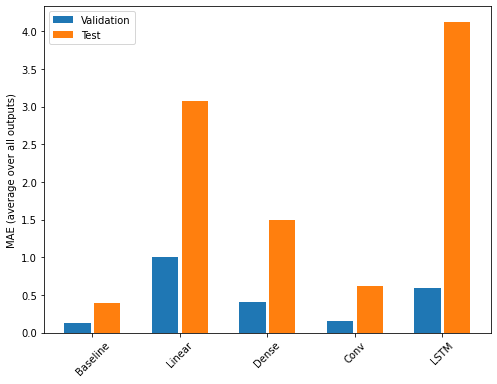

In [27]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()
for name, value in performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')

In [47]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.3613
Dense          : 0.8214
LSTM           : 4.5464
Residual LSTM  : 0.3755


Приведенные выше характеристики усреднены по всем выходным данным модели.

# Multi-step models
Как модели с одним выходом, так и модели с несколькими выходами в предыдущих разделах делали прогнозы с одним временным шагом , на один час вперед.

В этом разделе рассматривается, как расширить эти модели, чтобы делать прогнозы с несколькими временными шагами .

В многоэтапном прогнозировании модель должна научиться прогнозировать диапазон будущих значений. Таким образом, в отличие от одноступенчатой ​​модели, в которой предсказывается только одна точка будущего, многоступенчатая модель предсказывает последовательность будущих значений.

Есть два грубых подхода к этому:

Прогнозы одиночного выстрела, когда весь временной ряд прогнозируется сразу.
Прогнозы авторегрессии, при которых модель делает только одношаговые прогнозы, а ее выходные данные возвращаются в качестве входных данных.
В этом разделе все модели будут предсказывать все функции на всех выходных временных шагах .

Для многоступенчатой ​​модели обучающие данные снова состоят из ежечасных выборок. Однако здесь модели научатся предсказывать будущее на 24 часа, учитывая 24 часа прошлого.

Вот объект Window , который генерирует эти срезы из набора данных:

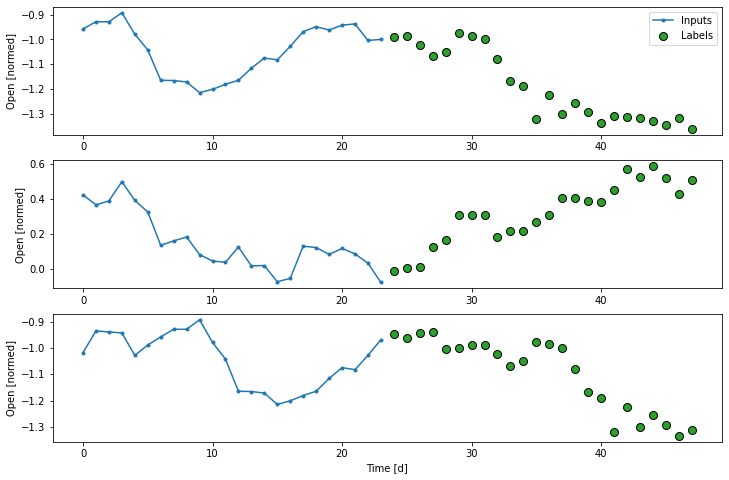

In [52]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS, label_columns=['Open'])

multi_window.plot()
plt.show()

multi_val_performance = {}
multi_performance = {}

# Baselines

Простая базовая линия для этой задачи — повторить последний временной шаг ввода для необходимого количества выходных временных шагов:

3/3 [==============================] - 0s 4ms/step - loss: 3.7317 - mean_absolute_error: 1.2053


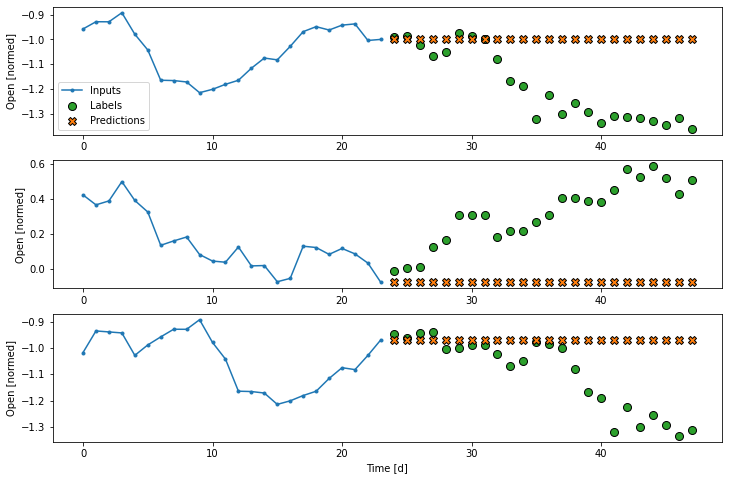

In [53]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Поскольку эта задача состоит в том, чтобы предсказать 24 часа в будущем, учитывая 24 часа в прошлом, другой простой подход состоит в том, чтобы повторить предыдущий день, предполагая, что завтра будет похоже:

3/3 [==============================] - 0s 5ms/step - loss: 3.8759 - mean_absolute_error: 1.3493


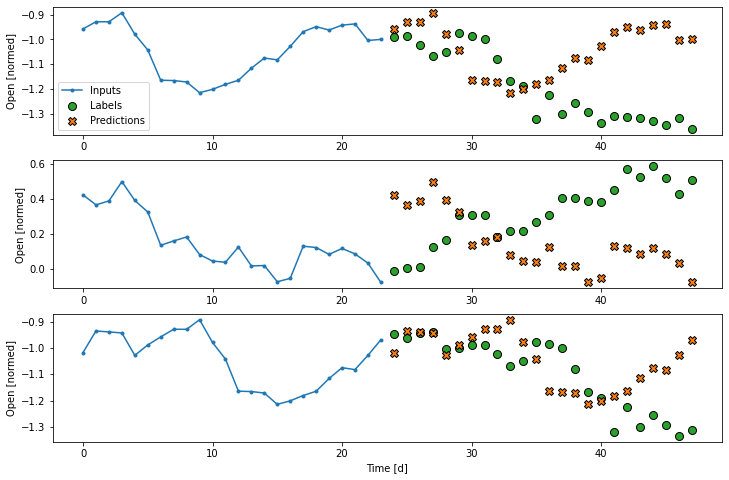

In [54]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

# Single-shot models
Одним из высокоуровневых подходов к этой проблеме является использование «однократной» модели, в которой модель делает прогноз всей последовательности за один шаг.

Это может быть эффективно реализовано как tf.keras.layers.Dense с выходными единицами OUT_STEPS*features . Модель просто должна преобразовать этот вывод в требуемый (OUTPUT_STEPS, features).

# Linear
Простая линейная модель, основанная на последнем входном временном шаге, работает лучше любой базовой линии, но у нее недостаточно мощности. Модель должна прогнозировать временные шаги OUTPUT_STEPS на основе одного входного временного шага с линейной проекцией. Он может зафиксировать только низкоразмерный фрагмент поведения, вероятно, основанный в основном на времени суток и времени года.

3/3 [==============================] - 0s 4ms/step - loss: 0.8631 - mean_absolute_error: 0.8080


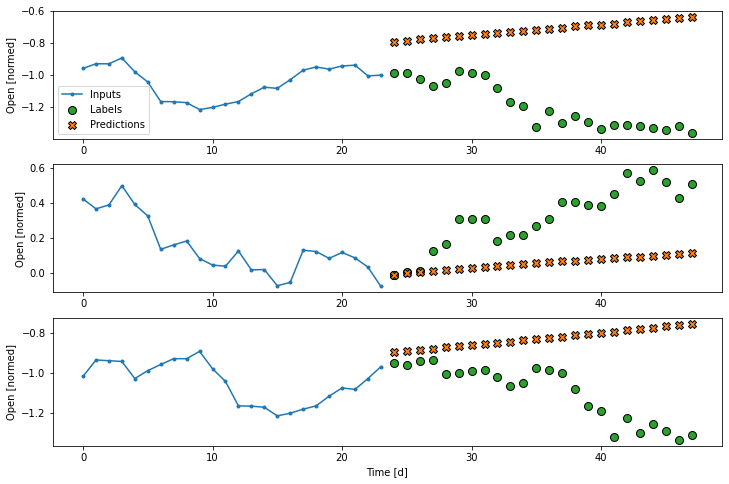

In [55]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

# Dense

Добавление tf.keras.layers.Dense между входом и выходом делает линейную модель более мощной, но по-прежнему основано только на одном временном шаге ввода.

3/3 [==============================] - 0s 5ms/step - loss: 0.7509 - mean_absolute_error: 0.7276


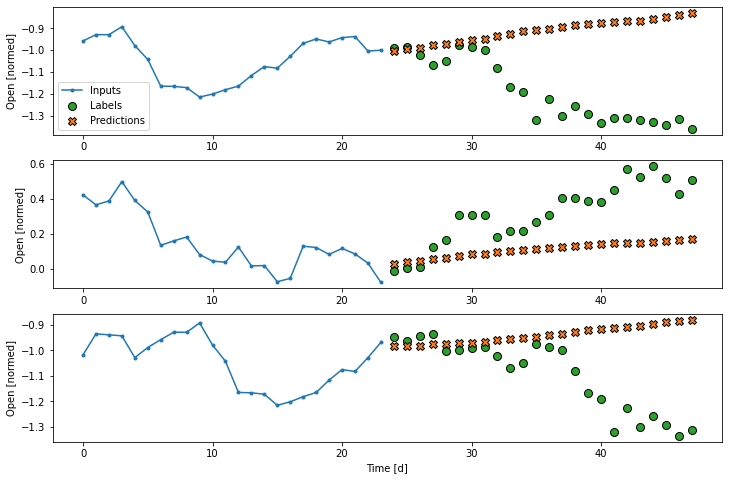

In [56]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

# CNN

Сверточная модель делает прогнозы на основе истории фиксированной ширины, что может привести к более высокой производительности, чем плотная модель, поскольку она может видеть, как все меняется с течением времени:

3/3 [==============================] - 0s 4ms/step - loss: 0.6820 - mean_absolute_error: 0.6932


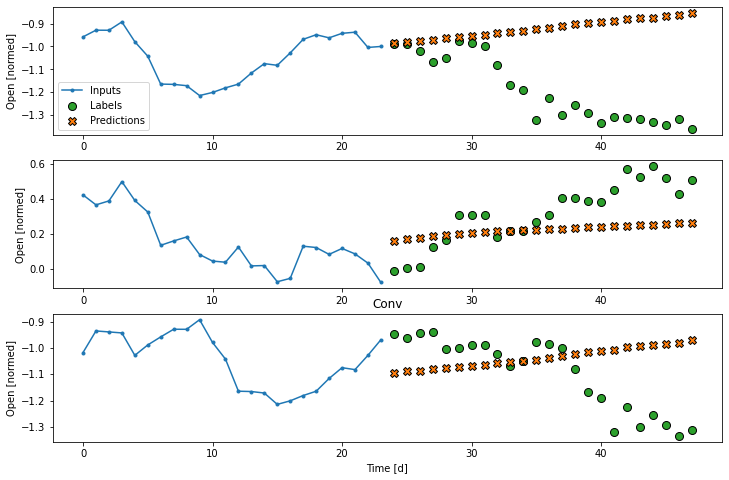

In [57]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)
plt.title("Conv")
plt.show()

# RNN
Рекуррентная модель может научиться использовать длинную историю входных данных, если она имеет отношение к прогнозам, которые делает модель. Здесь модель будет накапливать внутреннее состояние за 24 часа, прежде чем сделать один прогноз на следующие 24 часа.

В этом однократном формате LSTM нужно выводить только на последнем временном шаге, поэтому установите return_sequences=False в tf.keras.layers.LSTM .

3/3 [==============================] - 0s 8ms/step - loss: 3.4755 - mean_absolute_error: 1.7688


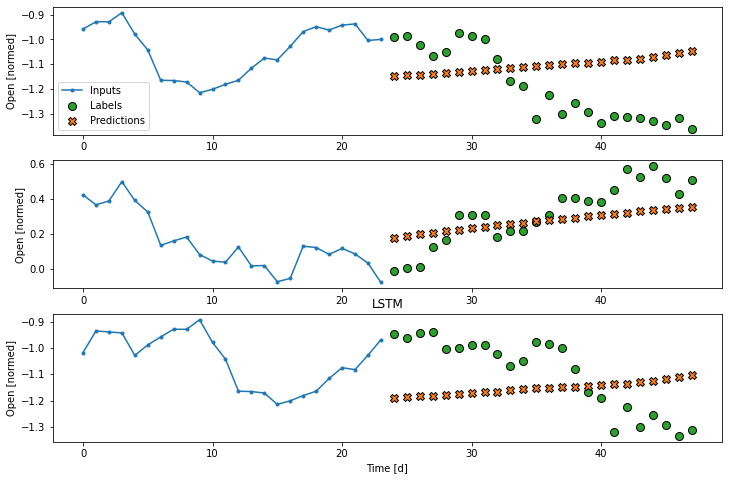

In [59]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)
plt.title("LSTM")
plt.show()

# Autoregressive model
Все вышеперечисленные модели предсказывают всю выходную последовательность за один шаг.

В некоторых случаях для модели может быть полезно разложить этот прогноз на отдельные временные шаги. Затем выходные данные каждой модели могут быть возвращены в себя на каждом шаге, и прогнозы могут быть сделаны в зависимости от предыдущего, как в классическом Генерация последовательностей с рекуррентными нейронными сетями .

Одним из явных преимуществ модели этого типа является то, что ее можно настроить для получения выходных данных различной длины.

Вы можете взять любую из одноэтапных моделей с несколькими выходами, обученных в первой половине этого руководства, и запустить авторегрессионный цикл обратной связи, но здесь вы сосредоточитесь на построении модели, специально обученной для этого.

# RNN

В этом руководстве строится только авторегрессионная модель RNN, но этот шаблон можно применить к любой модели, предназначенной для вывода одного временного шага.

Модель будет иметь ту же базовую форму, что и одноэтапные модели LSTM из более ранних версий: слой tf.keras.layers.LSTM , за которым следует слой tf.keras.layers.Dense , который преобразует выходные данные слоя LSTM в прогнозы модели.

tf.keras.layers.LSTM — это tf.keras.layers.LSTMCell , обернутый в tf.keras.layers.RNN более высокого уровня, который управляет для вас результатами состояния и последовательности (ознакомьтесь с рекуррентными нейронными сетями (RNN) с Keras). руководство для получения подробной информации).

В этом случае модель должна вручную управлять входными данными для каждого шага, поэтому она использует tf.keras.layers.LSTMCell непосредственно для интерфейса нижнего уровня с одним временным шагом.

In [60]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [61]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

Первый метод, в котором нуждается эта модель, — это метод warmup для инициализации ее внутреннего состояния на основе входных данных. После обучения это состояние будет захватывать соответствующие части истории ввода. Это эквивалентно одноэтапной модели LSTM из более раннего:

In [62]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

Этот метод возвращает прогноз с одним временным шагом и внутреннее состояние LSTM :

In [63]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 6])

С состоянием RNN и начальным прогнозом теперь вы можете продолжить итерацию модели, передавая прогнозы на каждом шагу назад в качестве входных данных.

Самый простой подход к сбору выходных прогнозов — использовать список Python и tf.stack после цикла.

In [64]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Протестируем эту модель на входных данных примера:

In [65]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 6)


Теперь обучим модель:

3/3 [==============================] - 0s 9ms/step - loss: 3.8685 - mean_absolute_error: 1.8700


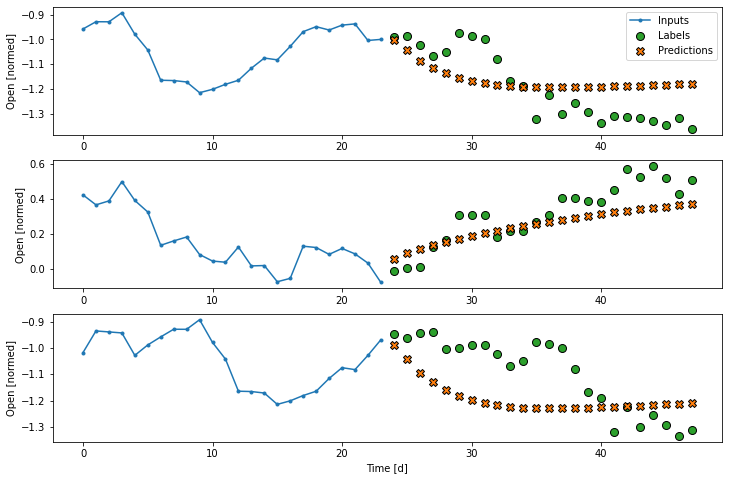

In [66]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

В этой проблеме явно наблюдается уменьшение отдачи в зависимости от сложности модели:

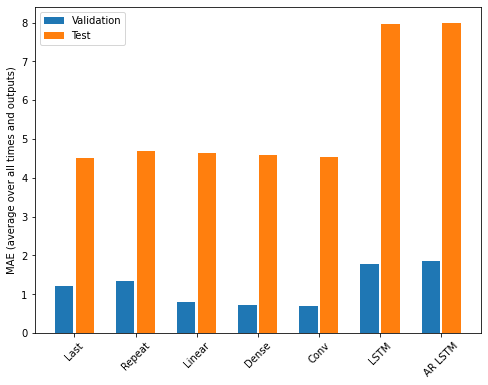

In [67]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [68]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 4.5216
Repeat  : 4.6946
Linear  : 4.6309
Dense   : 4.5926
Conv    : 4.5360
LSTM    : 7.9540
AR LSTM : 8.0001
